In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
import sys, io
import pandas as pd 
from ipynb.fs.full.Data_Processing import *
from ipynb.fs.full.evaluation import *
from braindecode.datasets.xy import create_from_X_y
import time
import numpy as np
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet , Deep4Net
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
from collections import namedtuple
import pickle
from sklearn.model_selection import KFold

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

In [3]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [4]:
def choose_cnn (cnn, trainset, validset , n_classes , device, cuda , n_epochs):
    # Extract number of chans and time steps from dataset
    n_chans = trainset[0][0].shape[0]
    input_window_samples = trainset[0][0].shape[1]

    if cnn == 'shallow':
        lr = 0.0625 * 0.01
        weight_decay = 0
        model =  ShallowFBCSPNet(n_chans, n_classes, input_window_samples=input_window_samples, final_conv_length="auto")
    else:
        lr = 1 * 0.01
        weight_decay = 0.5 * 0.001
        """
        For 30 samples, filter time_length = 1
        For 60 > samples, filter time length is left empty
        for 15 samples, filter_time length = 1, filter_length_2 = 1, filter_length_3 = 1
        """
        model =  Deep4Net(n_chans, n_classes, input_window_samples=input_window_samples,
                  final_conv_length="auto", pool_time_length=1, filter_time_length = 1,pool_time_stride=1)
    if cuda:
        model = model.cuda(0)

    batch_size = 32

    clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(validset),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,)
    return clf

In [5]:
def average(lst): 
    return sum(lst) / len(lst)

In [6]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [7]:
def is_slice_in_list(s,l):
    len_s = len(s) #so we don't recompute length of s on every iteration
    return any(s == l[i:len_s+i] for i in range(len(l) - len_s+1))

In [8]:
def kfold_predict (X,y, model_type, n_epochs, device, cuda):
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)

    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}

    total_predictions = []
    total_true = []
    num_classes = 0
    clf = None
    for train_index, test_index in kf.split(X):
        print("Train: ", train_index, "Validation: ", test_index)

        #Train/test split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))

        if is_slice_in_list(y_valid_classes, y_train_classes) == False: continue
        print(set(y_train))
        print(set(y_valid))

        size = len(X_train) + len(X_valid) #get dataset size

        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables 
        y_train, y_valid, le = categorise(y_train, y_valid)

        # Convert training and validation sets into a suitable format
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        trainset = create_from_X_y(X_train, y_train, drop_last_window=False)
        validset = create_from_X_y(X_valid, y_valid, drop_last_window=False)
        sys.stdout = save_stdout

        # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))

        # commence the training process
        time_start = time.time()
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        clf = choose_cnn ('deep', trainset, validset , num_classes , device, cuda, n_epochs).fit(trainset, y=None, epochs=n_epochs)
        sys.stdout = save_stdout
        print('Training completed created! Time elapsed: {} seconds'.format(time.time()-time_start))

        # make predictions
        y_pred = le.inverse_transform(clf.predict(X_valid))
        y_true = le.inverse_transform(y_valid)
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type)

        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        

    for key in results: # finallly average out the results 
        results[key] = average(results[key])
    print("Accuracy".format(results['Accuracy']))
    return results, np.concatenate(total_predictions), np.concatenate(total_true), num_classes, size , clf

In [9]:
# time_original = time.time()

# results = []
# labels = ['attention','interest','effort']
# window_size_samples = 30

# saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
# all_tests = load_file(saved_file)
# users = all_tests.keys()
# n_epochs  = 50
# model_type = 'clf'
# for user in users:
#     print("Working on user {0}".format(user))
#     torch.backends.cudnn.benchmark = True
    
#     for label in labels:
#         time_start = time.time()
#         dt = all_tests[user] # dictionary of all the individual tests per user

#         # convert the inputs  into #samples, channels, #timepoints format
#         X = np.array([np.array(x).transpose(0,2,1).astype(np.float32) for x in dt['inputs']])     
#         y = np.array([np.array(x) for x in dt[label]]) 

#         # train and make predictions
#         r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs)
#         print(r['Accuracy'])

#          # get results
#         Results = namedtuple("Results","user label n_epochs window_size time num_classes size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
#         results.append(Results(user, label, n_epochs, window_size_samples, time.time()-time_start,  num_classes,size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
#                               r['F1 Score Macro'], r['F1 Score Micro']))

#         # plot confusion matrix
#         cm = confusion_matrix(y_true, y_pred)
#         saved_file = "results/CNN/confusion/k fold/User_{0}_{1}.png".format(user,label)
#         plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)
        
#         #plot loss curve
#         plot_loss_curve(clf)
#         plt.savefig("results/CNN/loss curves/k fold/User_{0}_{1}.png".format(user,label))
#         print("Finished analysis on User {0}_{1}".format(user,label))
#     print("Finished analysis on User {0}".format(user))
# results  = pd.DataFrame(results).to_csv("results/CNN/tabulated/k fold/DeepCNN_Valid_performance_window_size_{0}_{1}_withclasses.csv".format(window_size_samples,label), index=False )
# final_duration = time.time()- time_original
# print("All analyses are complete! Time elapsed: {0}".format(final_duration))

In [10]:
# # save model 
# saved_file = "models/attention_user_1_with_fi.pickle"
# with open(saved_file, 'wb') as handle:            
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# saved_file_2 = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
# all_tests = load_file(saved_file_2)
# users = all_tests.keys()

# len(all_tests[1]['inputs'][0])

Working on label attention
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2544.7961390018463 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2628.3790464401245 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2615.619829893112 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2892.9763185977936 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2723.950149536133 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
0.2105285160768085
Normalized confusion matrix
[[0.01032023 0.1060859  0.38427683 0.46744574 0.0318713 ]
 [0.02391269 0.28796876 0.32070829 0.30262665 0.06478361]
 [0.03844107 0.36312849 0.27312228 0.2745411  0.05076705]
 [0.02887691 0.28301197 0.34291328 0.26016632 0.08503153]
 [0.07103934 0.21019405 0.33625731 0.28841042 0.09409888]]
Finished analysis on label attention
Working on label interest
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2550.5377101898193 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2634.011700153351 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2613.4632472991943 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2887.305757522583 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2722.4173328876495 seconds
Accuracy
0.23569359878432952
Normalized confusion matrix
[[0.04708459 0.1081303  0.32794963 0.44415549 0.07267999]
 [0.10119014 0.12352643 0.3601444  0.33064471 0.08449433]
 [0.17713436 0.06363186 0.32080145 0.33197556 0.10645676]
 [0.10788556 0.10322228 0.32126203 0.36797883 0.0996513 ]
 [0.05916127 0.09822685 0.21165212 0.45978047 0.17117929]]
Finished analysis on label interest
Working on label effort
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2543.8453574180603 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2629.2541992664337 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2625.5464568138123 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2887.147960662842 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 2732.4022040367126 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy
0.20884739775598163
Normalized confusion matrix
[[0.23080828 0.29651983 0.38061932 0.03953974 0.05251283]
 [0.35469477 0.2810532  0.24722301 0.08323048 0.03379854]
 [0.2317834  0.36021189 0.24961742 0.10476751 0.05361978]
 [0.32392894 0.34820352 0.20569086 0.07459207 0.0475846 ]
 [0.1810015  0.55781068 0.20212943 0.04458493 0.01447347]]
Finished analysis on label effort
Finished analysis on User all
All analyses are complete! Time elapsed: 45647.1068341732


NameError: name 'file' is not defined

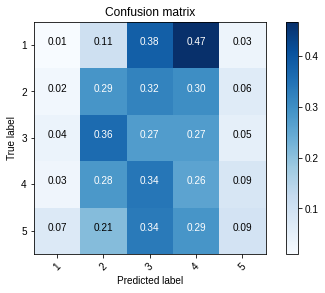

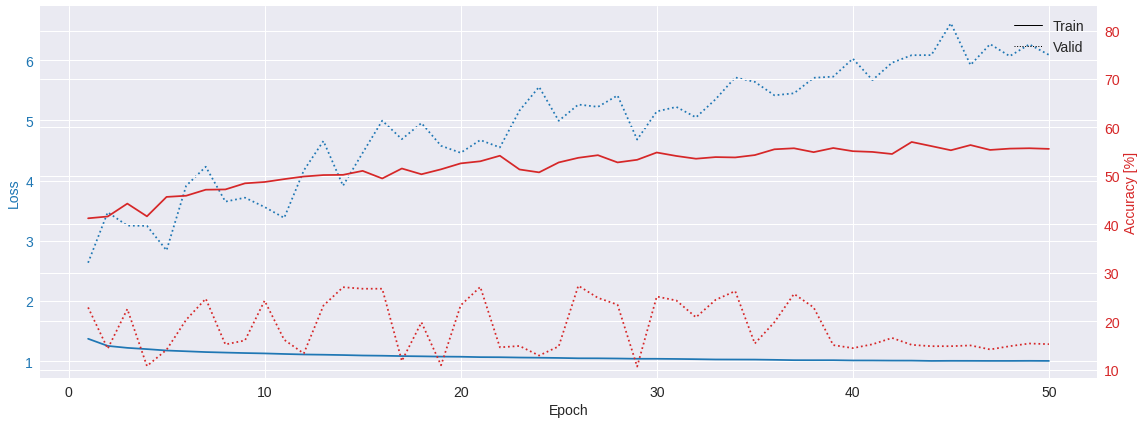

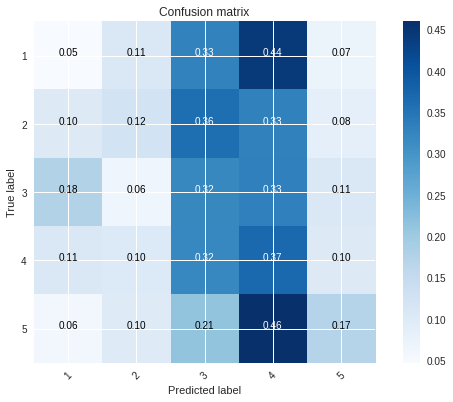

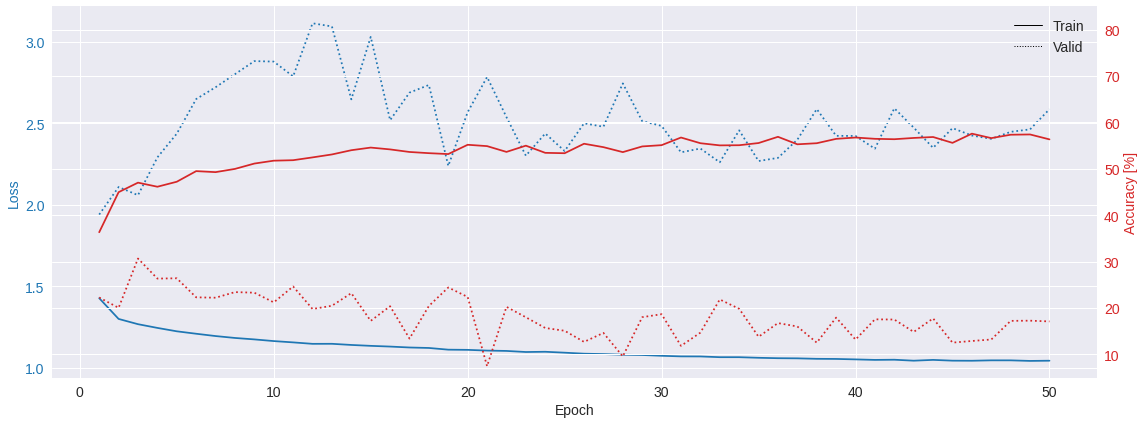

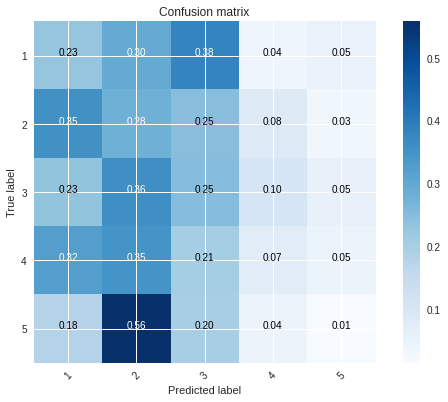

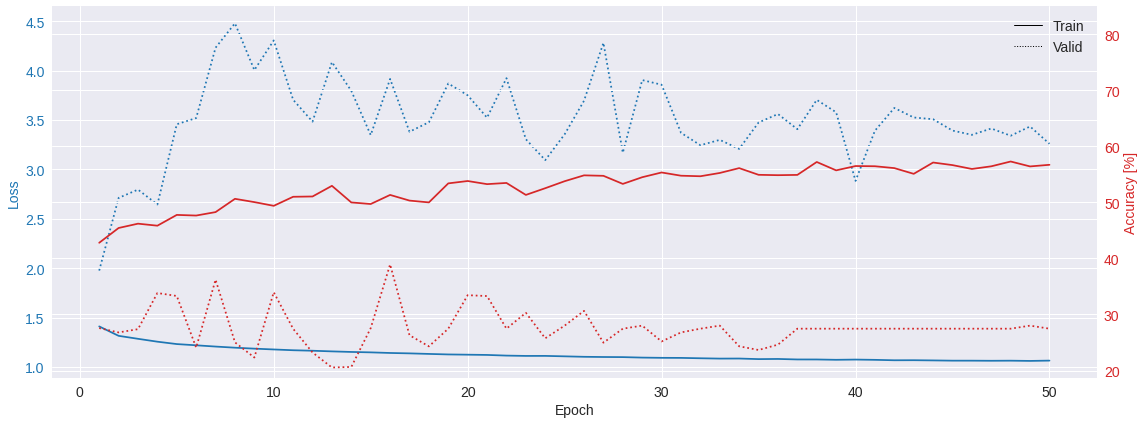

In [14]:
def run_cross_user():
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']
    window_size_samples = 30

    saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_30_window_annotated_EEG.pickle"
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    n_epochs  = 50
    model_type = 'clf'
    user ='all'
    torch.backends.cudnn.benchmark = True


    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()


        # convert the inputs  into #samples, channels, #timepoints format
        X = np.array([all_tests_agg[user]['inputs'].transpose(0,2,1).astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs, device, cuda)
        print(r['Accuracy'])

         # get results
        Results = namedtuple("Results","user label n_epochs window_size time num_classes size accuracy bal_acc precision recall f1_score_macro f1_score_micro")
        results.append(Results(user, label, n_epochs, window_size_samples, time.time()-time_start,  num_classes,size, r['Accuracy'], r['Balanced Accuracy'], r['Precision'], r['Recall'], 
                              r['F1 Score Macro'], r['F1 Score Micro']))

        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/confusion/k fold/cross user/Label_{0}.png".format(label)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

        #plot loss curve
        plot_loss_curve(clf)
        plt.savefig("results/CNN/loss curves/k fold/cross user/Label_{0}.png".format(label))
        print("Finished analysis on label {0}".format(label))
    print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/tabulated/k fold/DeepCNN_Valid_performance_window_size_{0}_cross_user.csv".format(window_size_samples), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))

    model_path =  "/cs/home/ybk1/Dissertation/data/models/cross_user_30_window.pickle"
    save_file(model_path,clf)

In [15]:
save_file(model_path,clf)

/cs/home/ybk1/python/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [18]:
cl

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(1, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 8), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin_2): Expression(